# Analysis of Variation Types in Feature Spaces

## 1. Comparison of Performance of a Traditional Learner in Different Variation Patterns
We try to observe any recurring pattern in terms of performance when variation pattern differs.

a8a full hinge_oco 0.16427123722241807
german full hinge_oco 0.30175
ionosphere full hinge_oco 0.36300000000000004
spambase full hinge_oco 0.23852173913043478
magic04 full hinge_oco 0.2410747147589253

a8a varying_gaussian hinge_oco 0.3259693338033133
german varying_gaussian hinge_oco 0.3958500000000001
ionosphere varying_gaussian hinge_oco 0.4275714285714286
spambase varying_gaussian hinge_oco 0.3979891304347826
magic04 varying_gaussian hinge_oco 0.39125085440874907

a8a varying_uniform hinge_oco 0.20137689460697922
german varying_uniform hinge_oco 0.3019
ionosphere varying_uniform hinge_oco 0.3654285714285714
spambase varying_uniform hinge_oco 0.30380434782608695
magic04 varying_uniform hinge_oco 0.32301908617698094



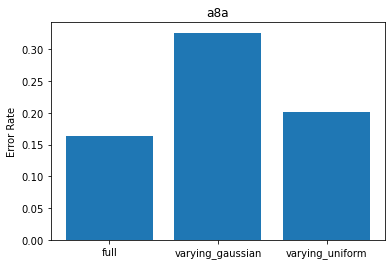

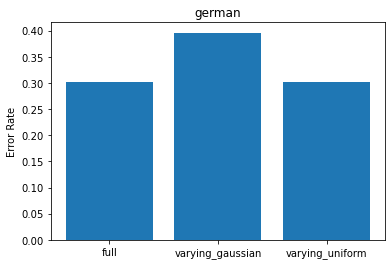

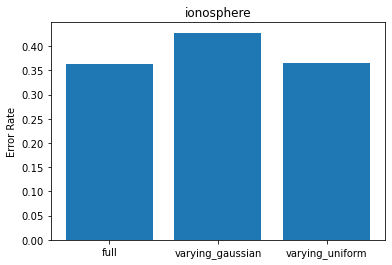

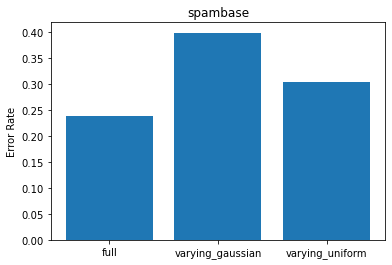

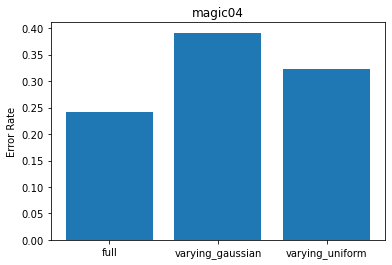

In [2]:
import model
import dataloader as dl
import numpy as np
import trainer
import parameters as p
import copy
import matplotlib.pyplot as plt

datasets = ['a8a', 'german', 'ionosphere', 'spambase', 'magic04']
model_type = 'hinge_oco'


# initialize results dict
results = {}
masks = {}
occurrences = {}

for dataset in datasets:
    results[dataset] = {}
    masks[dataset] = {}
    occurrences[dataset] = {}
    for scenario in p.scenarios:
        results[dataset][scenario] = 0
        masks[dataset][scenario] = []

for scenario in p.scenarios:
    for dataset_name in p.datasets:
        Xpath, ypath = dl.get_path(dataset_name)
        X, y = dl.read_dataset(Xpath, ypath)
        num_features = len(X[0])
        m = p.models[model_type](num_features, p.learning_rate)
        fold_errors, fold_losses, fold_weights, fold_masks = trainer.cross_validation(X, y, m, p.folds, p.scenarios[scenario])
        masks[dataset_name][scenario] = fold_masks
        results[dataset_name][scenario] = np.mean(fold_errors)
        print(dataset_name, scenario, model_type, np.mean(fold_errors))
    print()    
    
    
# plot results for each dataset
for dataset_name in datasets:
    plt.title(dataset_name)
    plt.ylabel('Error Rate')
    plt.bar(results[dataset_name].keys(), results[dataset_name].values())
    plt.show()

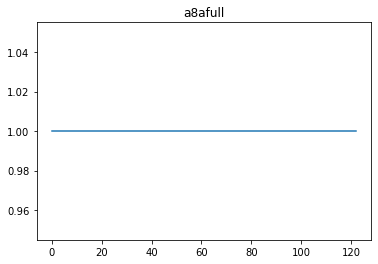

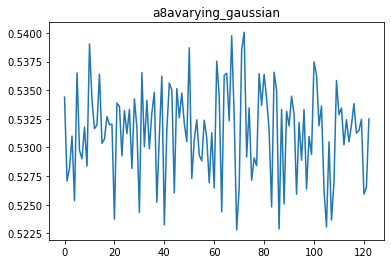

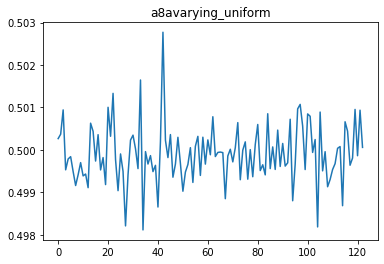

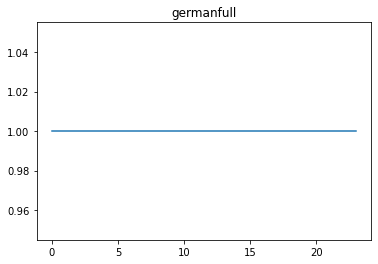

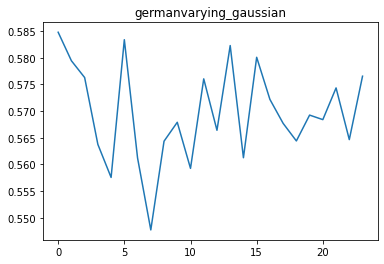

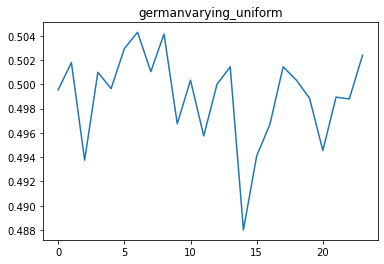

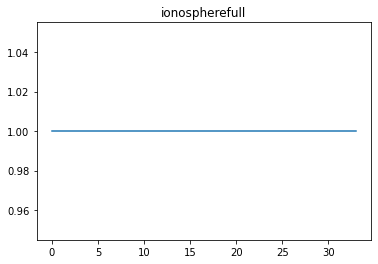

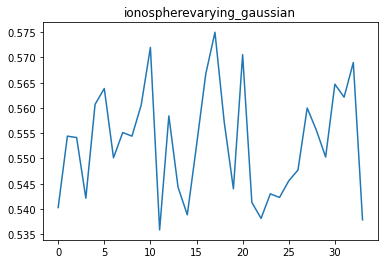

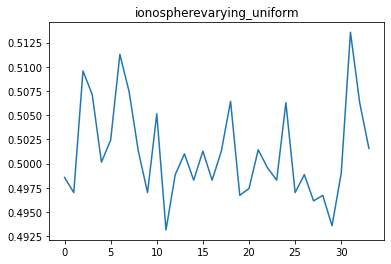

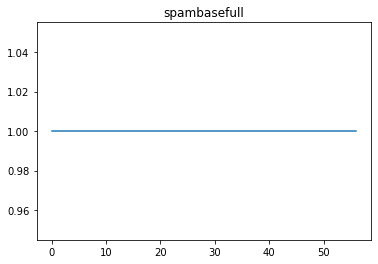

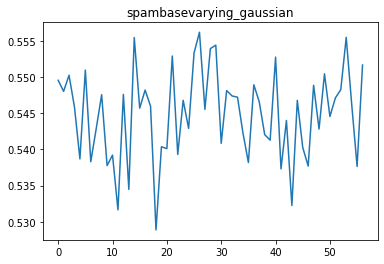

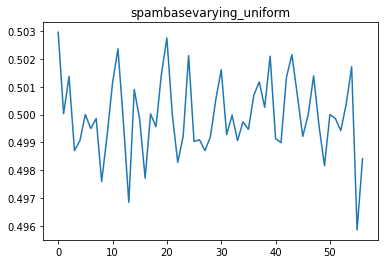

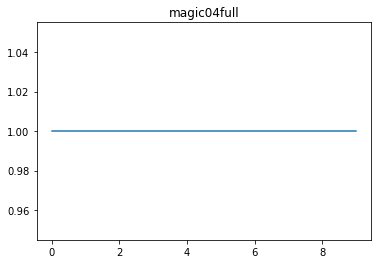

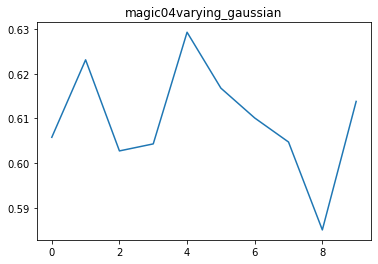

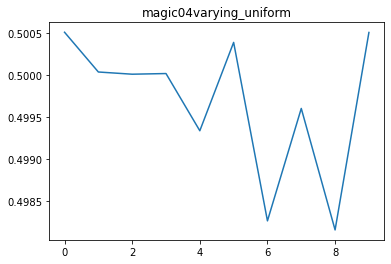

In [3]:
for key in masks:
    for scenario in p.scenarios:
        sum_masks = copy.deepcopy(masks[key][scenario][0])
        for i in range(1, len(masks[key][scenario])):
            sum_masks += masks[key][scenario][i]

        avg_sum_masks =  sum_masks / len(masks[key][scenario])
        avg_sum_masks = np.sum(avg_sum_masks, axis=0) / len(sum_masks)
        occurrences[key][scenario] = avg_sum_masks
        
        plt.title(key + scenario)
        plt.plot(occurrences[key][scenario])
        plt.show()

In [69]:
cov_mat=np.cov(masks["spambase"]["varying_gaussian"][0].T)

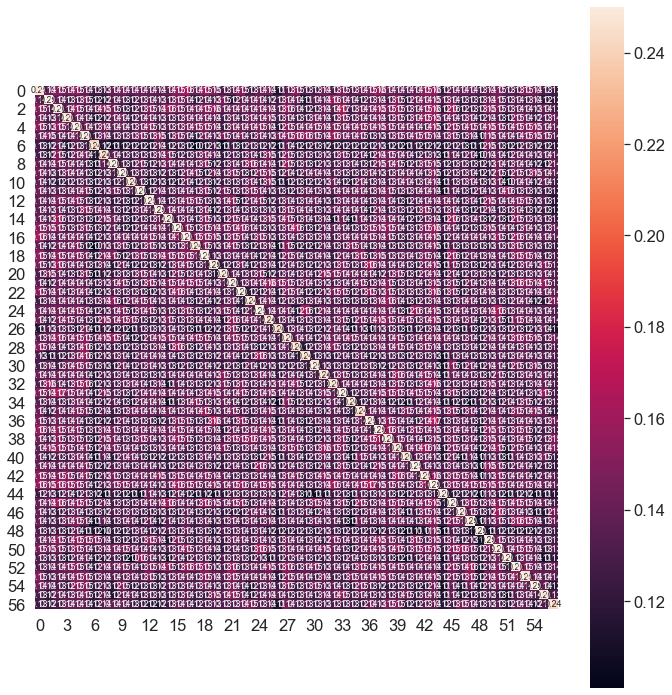

In [70]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 9})

plt.tight_layout()
plt.show()


In [71]:
cov_mat_uni=np.cov(masks["spambase"]["varying_uniform"][0].T)

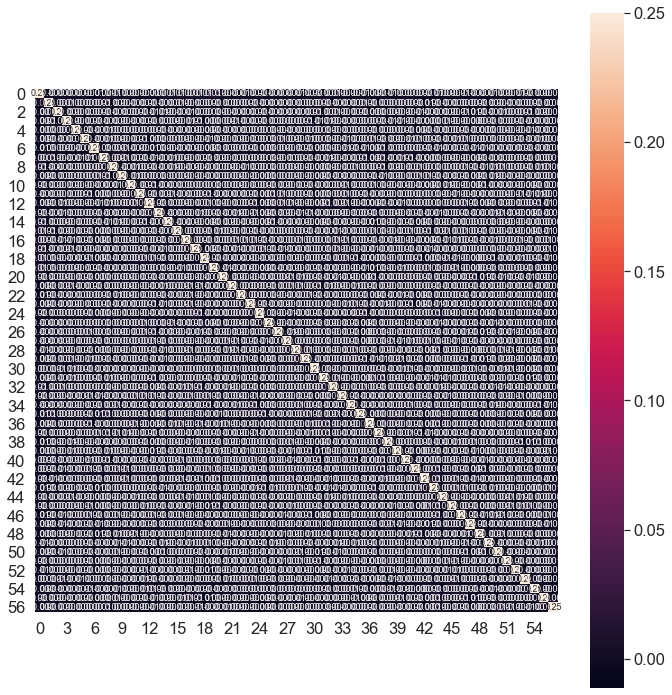

In [72]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat_uni,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 9})

plt.tight_layout()
plt.show()



In [41]:
cov_mat_uni

array([[ 2.49970978e-01, -2.29379412e-03, -1.26332811e-04,
        -1.87928593e-03,  1.75431887e-03, -4.11776676e-04,
        -1.45112013e-03,  8.42673994e-04,  9.09596240e-04,
        -9.34179923e-04],
       [-2.29379412e-03,  2.50012094e-01,  2.40273146e-03,
         1.84927514e-03, -1.85445066e-03, -3.87308006e-03,
         3.43384441e-03, -2.21971961e-03,  2.56295669e-03,
        -3.50640940e-04],
       [-1.26332811e-04,  2.40273146e-03,  2.50005232e-01,
         5.79933818e-04,  2.45560905e-03, -2.07688709e-03,
        -1.34606719e-03, -1.65787796e-04,  1.45803463e-03,
        -3.07741973e-03],
       [-1.87928593e-03,  1.84927514e-03,  5.79933818e-04,
         2.49996109e-01, -4.11306678e-04, -7.82447844e-04,
        -8.95424406e-04, -6.10348245e-04, -3.56554626e-04,
        -3.15079754e-03],
       [ 1.75431887e-03, -1.85445066e-03,  2.45560905e-03,
        -4.11306678e-04,  2.50012299e-01,  1.54234682e-03,
         2.43449506e-03,  2.51432568e-04, -1.71253602e-04,
         2.

In [73]:
cov_mat_full=np.cov(masks["spambase"]["full"][0].T)

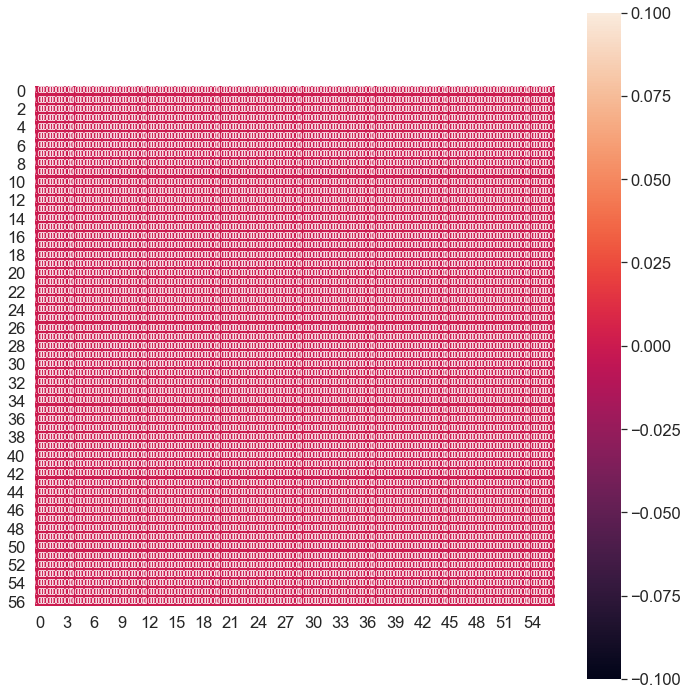

In [74]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat_full,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 9})

plt.tight_layout()
plt.show()


